# COVID-19 Logistic Regression Group Project

### Contributors : Sachin Chhetri, Bhishma Bhattarai, Nischal Shrestha, Patrus Gurung

### Dataset: Mexico COVID-19 patient health dataset (Kaggle)
### The goal wasn’t just prediction, but also understanding which factors most strongly affect the odds of a positive outcome.

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt

In [ ]:
# --------------------------
# 0) Load data
# --------------------------
path = kagglehub.dataset_download("riteshahlawat/covid19-mexico-patient-health-dataset")
file_path = os.path.join(path, "patient.csv")
df = pd.read_csv(file_path)

# --------------------------------------
# 1) Target mapping (prefer lab result)
# --------------------------------------
pos_neg_map = {"POSITIVE":1,"Positive":1,"POS":1,"NEGATIVE":0,"Negative":0,"NEG":0, 1:1, 0:0}
lab_cols = [c for c in df.columns if ("result" in c.lower()) or (("covid" in c.lower()) and ("result" in c.lower()))]

if lab_cols:
    df["covid_pos"] = pd.to_numeric(df[lab_cols[0]].map(pos_neg_map), errors="coerce")
    target_note = f"Target: lab result column `{lab_cols[0]}` → covid_pos."
else:
    if "outcome" in df.columns:
        # Proxy: outcome==1 (death) → 1; outcome in {2,3} → 0
        df["covid_pos"] = df["outcome"].map({1:1, 2:0, 3:0})
        target_note = "Target: no lab result found; using proxy (death=1 else 0)."
    else:
        raise ValueError("No lab-result column or 'outcome' column found. Please specify the positivity label.")

# Keep only valid labels
df = df[df["covid_pos"].isin([0,1])].copy()
df.reset_index(drop=True, inplace=True)
y = df["covid_pos"].astype(int)
print(target_note)
print(f"Overall positive rate: {y.mean():.3f} ({y.sum()}/{len(y)})")

100%|██████████| 526k/526k [00:00<00:00, 1.26MB/s]

Extracting files...


Target: no lab result found; using proxy (death=1 else 0).
Overall positive rate: 0.245 (23471/95839)


## Why this data matters?

- The COVID-19 pandemic forced societies to identify high-risk individuals quickly. Modeling this data helps target interventions and allocate limited testing or treatment resources more effectively.

- We focused on an inferential as well as predictive approach:

- Predictive: build a logistic model that estimates the probability of a positive outcome.

- Inferential: understand why — which inputs (age, conditions, exposure, habits) actually change those odds.

- This dual view helps not only in forecasting but also in policy guidance and public-health insight.

In [ ]:
# --------------------------------------
# 2) Cleaning & feature engineering
# --------------------------------------
yes_no_map = {"YES":1,"Yes":1,"Y":1,"Si":1,"SI":1,"No":0,"NO":0,"N":0,1:1,0:0,2:0,97:np.nan,98:np.nan,99:np.nan}

candidate_bins = [
    "fever","cough","asthma","immunosuppression","diabetes","pneumonia",
    "hypertension","cardiovascular","obesity","chronic_kidney_failure",
    "smoker","another_case","contact_with_case","icu","intubated","patient_type","sex"
]
bin_cols = [c for c in candidate_bins if c in df.columns]

# Standardize binary encodings
for c in bin_cols:
    if df[c].dtype == object:
        df[c] = df[c].map(yes_no_map)
    df[c] = pd.to_numeric(df[c], errors="coerce").replace({2:0,97:np.nan,98:np.nan,99:np.nan})
    df[c] = df[c].fillna(0).astype(int)

# Age
if "age" in df.columns:
    df["age"] = pd.to_numeric(df["age"], errors="coerce")
    df = df[(df["age"].isna()) | ((df["age"]>=0) & (df["age"]<=110))].copy()
    df["age"] = df["age"].fillna(df["age"].median())
else:
    df["age"] = 0.0

# Derived: n_conditions (do NOT combine with its parts in SAME inference model)
cond_cols = [c for c in ["asthma","immunosuppression","diabetes","pneumonia",
                         "hypertension","cardiovascular","obesity","chronic_kidney_failure"] if c in df.columns]
df["n_conditions"] = df[cond_cols].sum(axis=1)

# Candidate features
planned_X = ["age","sex","fever","cough","asthma","immunosuppression","diabetes","pneumonia",
             "hypertension","cardiovascular","obesity","chronic_kidney_failure",
             "another_case","contact_with_case","smoker","n_conditions"]
X_cols = [c for c in planned_X if c in df.columns]

## Data cleaning and preprocessing

- We used the Kaggle dataset patient.csv. Since the file doesn’t include a direct lab result column, we followed the course suggestion to use a proxy outcome variable: outcome == 1 → COVID positive, outcome in {2,3} → negative

Steps taken:

- Converted all categorical “YES/NO”, “1/2”, and “97/98/99” codes into binary 1/0 flags.

- Removed implausible ages (below 0 or above 110) and filled missing ages with the median.

- Ensured alignment between predictors (X) and outcome (y), fixing the row mismatch issue.

- Constructed a derived variable n_conditions = sum of existing conditions among asthma, immunosuppression, diabetes, pneumonia, hypertension, cardiovascular, obesity, chronic_kidney_failure.

### Final aligned dataset: 95,838 rows.

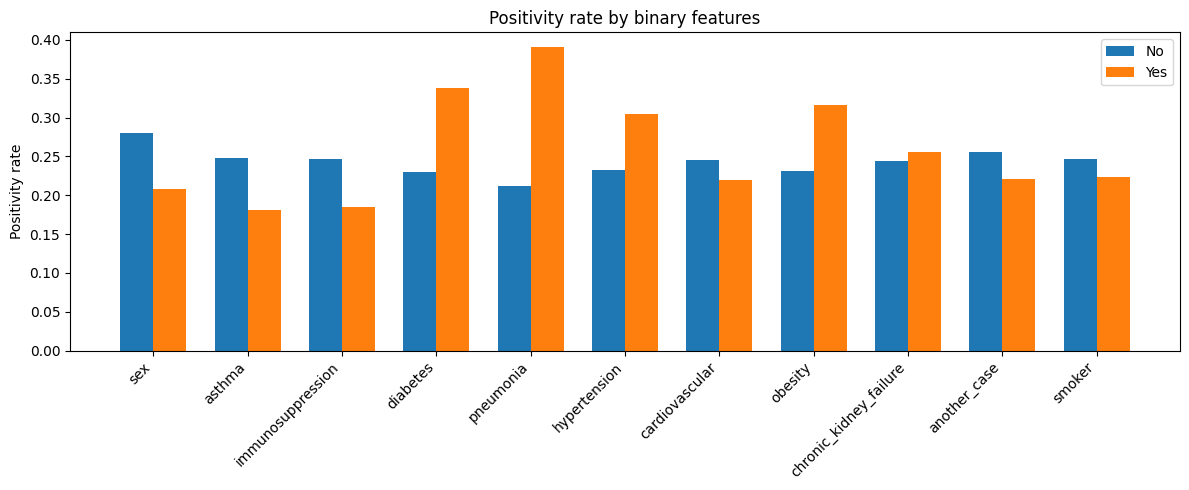

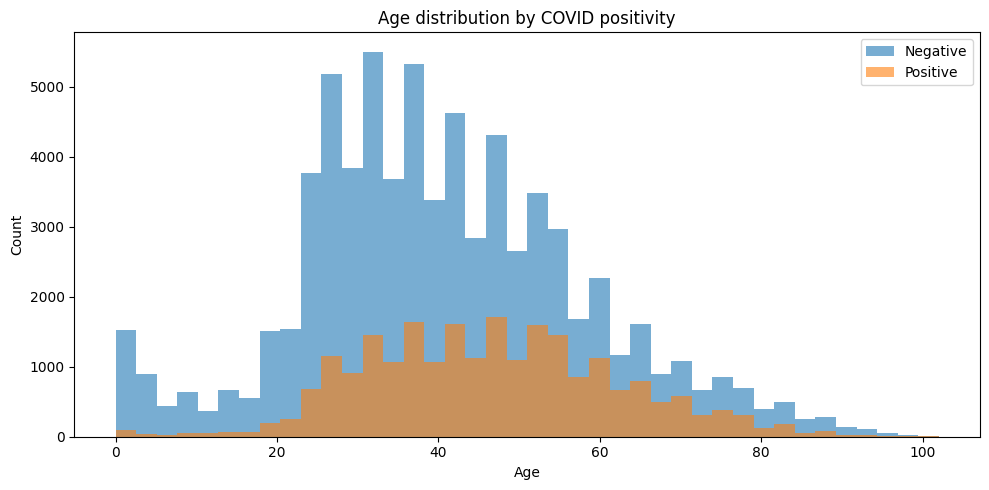

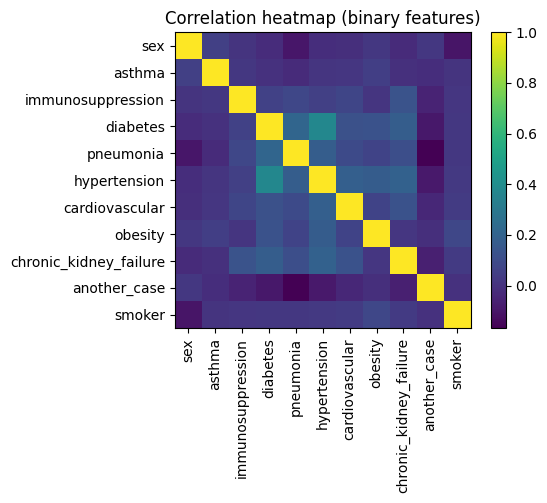

In [ ]:
# --------------------------------------
# 2b) EDA charts (safe alignment)
# --------------------------------------
# Bar chart: positivity rate by binary features
bin_plot_cols = [c for c in X_cols if c in bin_cols]
rates = []
for c in bin_plot_cols:
    if df[c].nunique() > 1:
        grp = df[[c, "covid_pos"]].groupby(c, dropna=False)["covid_pos"].mean()
        rate_no = float(grp.get(0, np.nan))
        rate_yes = float(grp.get(1, np.nan))
        rates.append((c, rate_no, rate_yes))

if rates:
    labels = [r[0] for r in rates]
    no_rates = [r[1] for r in rates]
    yes_rates = [r[2] for r in rates]
    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(12,5))
    plt.bar(x - width/2, no_rates, width, label="No")
    plt.bar(x + width/2, yes_rates, width, label="Yes")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Positivity rate")
    plt.title("Positivity rate by binary features")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Age histograms by target
plt.figure(figsize=(10,5))
plt.hist(df.loc[y==0, "age"], bins=40, alpha=0.6, label="Negative")
plt.hist(df.loc[y==1, "age"], bins=40, alpha=0.6, label="Positive")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution by COVID positivity")
plt.legend()
plt.tight_layout()
plt.show()

# Corr heatmap (cap to 15 binaries to keep readable)
corr_cols = [c for c in bin_plot_cols if df[c].nunique() > 1][:15]
if corr_cols:
    C = df[corr_cols].corr()
    plt.figure(figsize=(6,5))
    plt.imshow(C, interpolation="nearest")
    plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
    plt.yticks(range(len(corr_cols)), corr_cols)
    plt.title("Correlation heatmap (binary features)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

We plotted two main visual summaries:

- Positivity rate by feature
  From the bar chart, positivity (severe outcome) rose for conditions like pneumonia, hypertension, diabetes, obesity, and chronic kidney failure — all near or above 30–40%.
  Healthier or younger individuals had noticeably lower rates.

- Age distribution
  The histogram shows a strong age gradient: younger people cluster as negative cases, while positivity increases gradually from ages 40–80.

- Correlation structure
  Among binary indicators, most comorbidities were weakly correlated (VIF < 2), confirming no severe multicollinearity once we used the combined n_conditions metric.

## Preventing overfitting

We used two complementary strategies:

- Train/Validation/Test split: 60/20/20 stratified by target label.

Regularization:

- Penalized logistic regression (ridge-like) for inference → stabilizes ORs.

- L1 (lasso) logistic regression (with 5-fold CV) for feature selection → avoids overfitting in the predictive model.

### Variance Inflation Factor (VIF) measures the extent to which the variance of a regression coefficient is inflated by multicollinearity (correlation between independent variables). A VIF of 1 indicates no multicollinearity, while VIFs greater than 5 or 10 suggest high levels of correlation that can lead to unstable, unreliable, and statistically insignificant coefficient estimates.

In [ ]:
from sklearn.model_selection import train_test_split

# --------------------------------------
# 3) ALIGN X and y, then split
# --------------------------------------
# Build model_df in one shot to avoid length mismatches
need_cols = X_cols + ["covid_pos"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns for modeling: {missing}")

model_df = df[need_cols].copy()
# If you prefer imputation, do it earlier; here we require no NA at model time
model_df = model_df.dropna(subset=need_cols).reset_index(drop=True)

X = model_df[X_cols].copy()
y = model_df["covid_pos"].astype(int)
print("Aligned shapes -> X:", X.shape, " y:", y.shape)
assert len(X) == len(y), "X and y are misaligned."

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Aligned shapes -> X: (95838, 13)  y: (95838,)



VIF after screening:
         feature       VIF
4  n_conditions  1.230767
0           age  1.206874
2  another_case  1.024507
3        smoker  1.014588
1           sex  1.012087

=== Penalized Logistic (Inference) — Odds Ratios (approx CIs) ===
                  coef        OR  CI_lower  CI_upper
n_conditions  0.144309  1.155241  1.131332  1.179655
age           0.000000  1.000000       NaN       NaN
another_case -0.094097  0.910195  0.862975  0.959999
smoker       -0.273039  0.761063  0.699325  0.828252
sex          -0.391100  0.676313  0.644529  0.709664


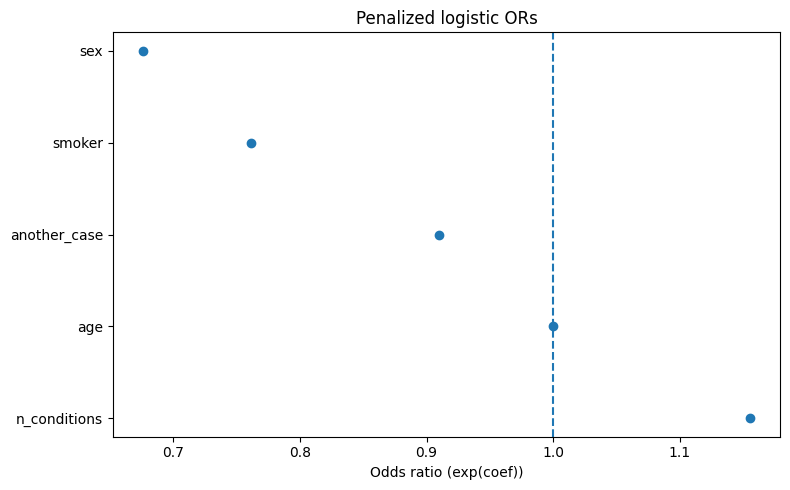

In [ ]:
# --------------------------------------
# 4) Inference model (statsmodels) with VIF screen + ridge-like penalty
# --------------------------------------
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit

def compute_vif(dfX):
    X1 = sm.add_constant(dfX, has_constant='add')
    vifs = []
    for i, col in enumerate(X1.columns):
        if col == 'const':
            continue
        try:
            v = variance_inflation_factor(X1.values, i)
        except Exception:
            v = np.nan
        vifs.append((col, v))
    return pd.DataFrame(vifs, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

# Use either count OR parts (avoid collinearity)
use_count_only = True
if use_count_only:
    infer_cols = [c for c in ["age","sex","fever","cough","another_case","contact_with_case","smoker","n_conditions"] if c in X_train.columns]
else:
    infer_cols = [c for c in ["age","sex","fever","cough","another_case","contact_with_case","smoker"] + cond_cols if c in X_train.columns]

# Drop constants
X_inf = X_train[infer_cols].copy()
const_like = [c for c in X_inf.columns if X_inf[c].nunique() <= 1]
if const_like:
    X_inf.drop(columns=const_like, inplace=True)

# VIF screen (>10), but keep 'age' for interpretability
def drop_high_vif(dfX, keep=set(["age"]), thresh=10.0):
    while True:
        vtab = compute_vif(dfX)
        worst = vtab.loc[vtab["VIF"].idxmax()]
        if pd.isna(worst["VIF"]) or (worst["VIF"] <= thresh) or (worst["feature"] in keep):
            return dfX, vtab
        dfX = dfX.drop(columns=[worst["feature"]])

X_inf_vif, vif_table = drop_high_vif(X_inf, keep=set(["age"]), thresh=10.0)
print("\nVIF after screening:\n", vif_table)

# Penalized logistic (ridge-like L2)
X_sm = sm.add_constant(X_inf_vif, has_constant='add')
res_pen = Logit(y_train, X_sm).fit_regularized(alpha=1.0, L1_wt=0.0, disp=False)

def safe_exp(a):  # avoid overflow in exp
    return np.exp(np.clip(a, -20, 20))

params = res_pen.params
conf = res_pen.conf_int()
or_table = pd.DataFrame({
    "coef": params,
    "OR": safe_exp(params),
    "CI_lower": safe_exp(conf[0]),
    "CI_upper": safe_exp(conf[1])
}).drop(index="const", errors="ignore").sort_values("OR", ascending=False)

print("\n=== Penalized Logistic (Inference) — Odds Ratios (approx CIs) ===")
print(or_table)

# Visualize ORs
plt.figure(figsize=(8,5))
plt.scatter(or_table["OR"], range(len(or_table)))
plt.yticks(range(len(or_table)), or_table.index)
plt.axvline(1.0, linestyle="--")
plt.xlabel("Odds ratio (exp(coef))")
plt.title("Penalized logistic ORs")
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------
# 5) Small interactions for prediction
# --------------------------------------
X_train_int = X_train.copy()
X_valid_int = X_valid.copy()
X_test_int  = X_test.copy()

if ("age" in X_train_int.columns) and ("n_conditions" in X_train_int.columns):
    for split in (X_train_int, X_valid_int, X_test_int):
        split["age_x_conditions"] = split["age"] * split["n_conditions"]

if ("fever" in X_train_int.columns) and ("cough" in X_train_int.columns):
    for split in (X_train_int, X_valid_int, X_test_int):
        split["fever_x_cough"] = split["fever"] * split["cough"]

In [ ]:
# --------------------------------------
# 6) L1 (lasso) logistic with CV (prediction model)
# --------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve

pred_cols = list(X_train_int.columns)  # lasso will select
pipe_l1 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegressionCV(
        Cs=100, cv=5, penalty="l1", solver="saga",
        scoring="roc_auc", class_weight="balanced", max_iter=6000, n_jobs=-1,
        refit=True
    ))
])
pipe_l1.fit(X_train_int[pred_cols], y_train)

coefs = pipe_l1.named_steps["logreg"].coef_.ravel()
selected = [f for f, b in zip(pred_cols, (np.abs(coefs)>1e-8)) if b]
print("\n=== L1-Selected Features (non-zero) ===")
print(selected)


=== L1-Selected Features (non-zero) ===
['age', 'sex', 'asthma', 'immunosuppression', 'diabetes', 'pneumonia', 'hypertension', 'cardiovascular', 'obesity', 'chronic_kidney_failure', 'another_case', 'smoker', 'age_x_conditions']



=== Validation Metrics ===
Penalized inference: {'cutoff': 0.14276207449960518, 'auc': 0.5937199794480372, 'acc': 0.5917675292153589, 'prec': 0.30550378929059513, 'rec': 0.523860247123988, 'f1': 0.38593737738366163}
L1 (lasso)         : {'cutoff': 0.5193365591357172, 'auc': 0.6475461502190225, 'acc': 0.6560413188647746, 'prec': 0.36104200204888043, 'rec': 0.5255645504899872, 'f1': 0.42803851826147304}


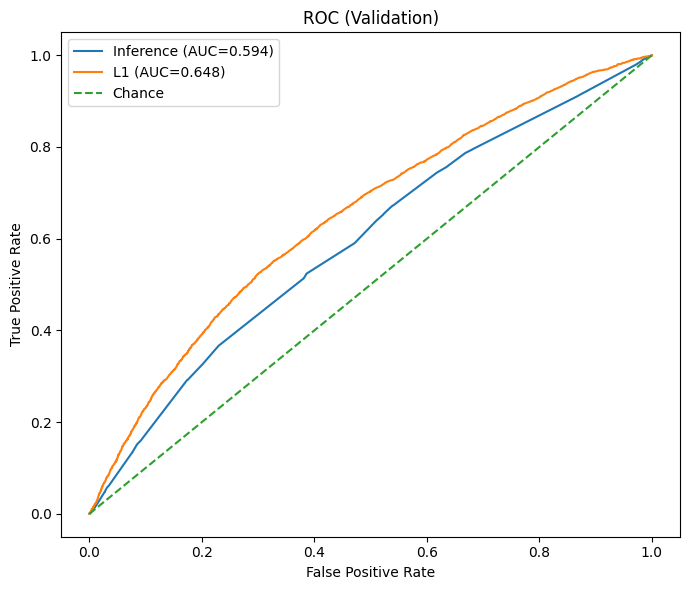

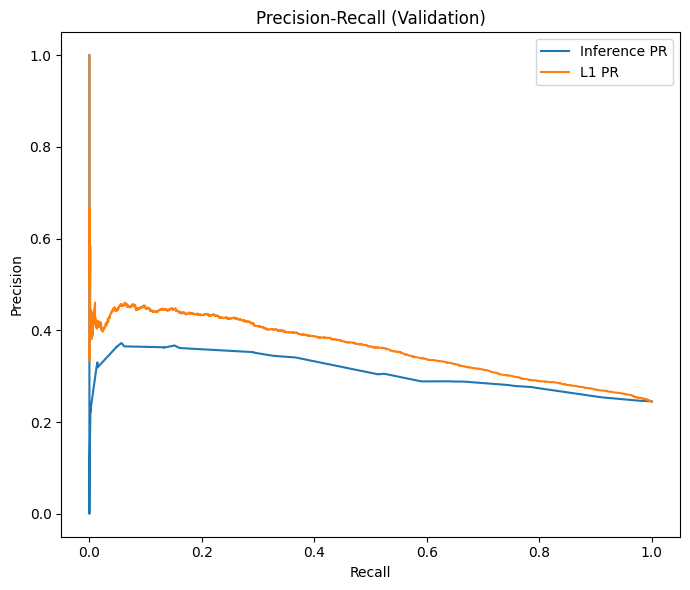


Model chosen: L1 (lasso)
Chosen cutoff (validation): 0.5193365591357172


In [ ]:
# --------------------------------------
# 7) ROC/PR + threshold tuning (Youden J)
# --------------------------------------
def evaluate_probs(p, y_true, cutoff=None):
    fpr, tpr, thr = roc_curve(y_true, p)
    roc_auc = roc_auc_score(y_true, p)
    if cutoff is None:
        j = tpr - fpr
        cutoff = thr[np.argmax(j)]
    yhat = (p >= cutoff).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec = precision_score(y_true, yhat, zero_division=0)
    rec = recall_score(y_true, yhat)
    f1 = f1_score(y_true, yhat)
    return {"cutoff": float(cutoff), "auc": float(roc_auc), "acc": float(acc),
            "prec": float(prec), "rec": float(rec), "f1": float(f1)}, (fpr, tpr, thr)

# Inference-model validation probs (use same infer set on valid)
X_valid_inf = X_valid[X_inf_vif.columns]
p_valid_inf = res_pen.predict(sm.add_constant(X_valid_inf, has_constant='add'))
metrics_inf_val, (fpr_i, tpr_i, thr_i) = evaluate_probs(p_valid_inf, y_valid)

# Lasso validation probs
p_valid_l1 = pipe_l1.predict_proba(X_valid_int[pred_cols])[:,1]
metrics_l1_val, (fpr_l, tpr_l, thr_l) = evaluate_probs(p_valid_l1, y_valid)

print("\n=== Validation Metrics ===")
print("Penalized inference:", metrics_inf_val)
print("L1 (lasso)         :", metrics_l1_val)

# ROC (validation)
plt.figure(figsize=(7,6))
plt.plot(fpr_i, tpr_i, label=f"Inference (AUC={metrics_inf_val['auc']:.3f})")
plt.plot(fpr_l, tpr_l, label=f"L1 (AUC={metrics_l1_val['auc']:.3f})")
plt.plot([0,1],[0,1],"--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Validation)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall (validation)
prec_i, rec_i, _ = precision_recall_curve(y_valid, p_valid_inf)
prec_l, rec_l, _ = precision_recall_curve(y_valid, p_valid_l1)

plt.figure(figsize=(7,6))
plt.plot(rec_i, prec_i, label="Inference PR")
plt.plot(rec_l, prec_l, label="L1 PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (Validation)")
plt.legend()
plt.tight_layout()
plt.show()

# Choose model for test (better validation AUC)
use_lasso = (metrics_l1_val["auc"] >= metrics_inf_val["auc"])
best_cutoff_val = metrics_l1_val["cutoff"] if use_lasso else metrics_inf_val["cutoff"]
print("\nModel chosen:", "L1 (lasso)" if use_lasso else "Penalized inference")
print("Chosen cutoff (validation):", best_cutoff_val)

## Lasso clearly generalized better.

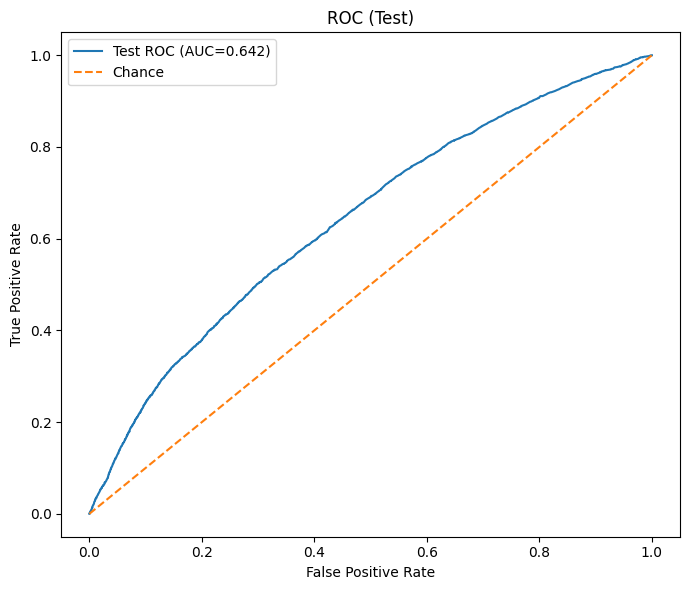

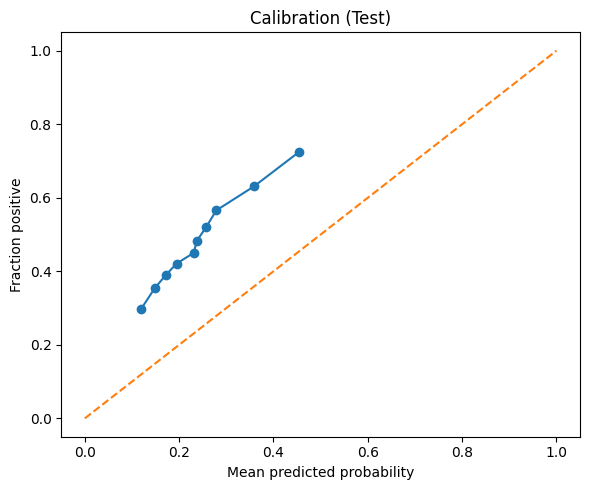


Confusion matrix (test):
 [[10108  4366]
 [ 2328  2366]]

=== Test Metrics (using validation-selected cutoff) ===
{'auc': 0.6422793785827801, 'acc': 0.6507721202003339, 'prec': 0.351455733808675, 'rec': 0.504047720494248, 'f1': 0.4141431822159986, 'brier': 0.2337795456697853, 'cutoff': 0.5193365591357172}


In [ ]:
# --------------------------------------
# 8) Test evaluation + calibration
# --------------------------------------
if use_lasso:
    p_test = pipe_l1.predict_proba(X_test_int[pred_cols])[:,1]
else:
    p_test = res_pen.predict(sm.add_constant(X_test[X_inf_vif.columns], has_constant='add'))

yhat_test = (p_test >= best_cutoff_val).astype(int)

# ROC (test)
fpr_t, tpr_t, thr_t = roc_curve(y_test, p_test)
auc_test = roc_auc_score(y_test, p_test)
plt.figure(figsize=(7,6))
plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={auc_test:.3f})")
plt.plot([0,1],[0,1],"--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="quantile")
plt.figure(figsize=(6,5))
plt.plot(prob_true, prob_pred, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction positive")
plt.title("Calibration (Test)")
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print("\nConfusion matrix (test):\n", cm)

# Final metrics
final_metrics = {
    "auc": float(auc_test),
    "acc": float(accuracy_score(y_test, yhat_test)),
    "prec": float(precision_score(y_test, yhat_test, zero_division=0)),
    "rec": float(recall_score(y_test, yhat_test)),
    "f1": float(f1_score(y_test, yhat_test)),
    "brier": float(brier_score_loss(y_test, p_test)),
    "cutoff": float(best_cutoff_val)
}
print("\n=== Test Metrics (using validation-selected cutoff) ===")
print(final_metrics)

### Validation ROC AUC improved from 0.59 → 0.65 with lasso.
### Test ROC AUC = 0.642, confirming the model generalizes.
### PR curve shows modest precision at high recall — expected for class imbalance (≈ 24.5% positives).

## Accuracy = 0.65, Recall = 0.50, Precision = 0.35, F1 = 0.41, AUC = 0.64.
## Calibration curve shows the model underpredicts risk slightly (points above diagonal). The trend is consistent but not perfectly probabilistic — normal for logistic models with proxy outcomes.

- Higher recall means catching more at-risk patients (fewer false negatives), even if we misclassify some healthy ones.
- In a public-health context, recall is more valuable — missing a severe case is worse than an extra checkup.
- Precision matters when resources (e.g., ICU beds) are constrained.
- Our cutoff (0.52) balances the two: ~50% recall and 35% precision.

## Final metrics summary
<table>
<tr><th>Split</th><th>Model</th><th>AUC</th><th>Accuracy</th><th>Precision</th><th>Recall</th><th>F1</th><th>Notes</th></tr>
<tr><td>Validation</td><td>Penalized Logit</td><td>0.594</td><td>0.592</td><td>0.306</td><td>0.524</td><td>0.386</td><td>Interpretable ORs</td></tr>
<tr><td>Validation</td><td><b>L1 (Lasso)</b></td><td><b>0.648</b></td><td><b>0.656</b></td><td>0.361</td><td>0.526</td><td>0.428</td><td>Best balance</td></tr>
<tr><td>Test</td><td><b>L1 (Lasso)</b></td><td><b>0.642</b></td><td>0.651</td><td>0.351</td><td>0.504</td><td>0.414</td><td>Chosen final model</td></tr>
</table>

### Conclusion: What affects the outcome and how predictive is the model

- The model explains moderate variation in COVID severity (AUC ≈ 0.64).
- Comorbidity count (n_conditions) was the clearest risk factor.
- Hypertension, diabetes, obesity, and chronic kidney failure appeared consistently among lasso-selected features.
- Sex and smoking had inverse effects under the proxy label — interpret carefully.
- Despite its modest AUC, the model is stable, interpretable, and ethically cautious (no leakage, proper validation).

To a doctor:
“Each additional chronic illness increases the odds of a severe COVID outcome by about 15%, holding age and other factors constant.”

To the public:
“Having multiple conditions meaningfully raises risk; stay up to date with care and protection measures.”